In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sns.set_theme()

## Load data

In [97]:
data = pd.read_csv('data/starships_clean.csv', index_col='id')

In [98]:
# Cast again date
data['stream_date'] = pd.to_datetime(data['stream_date'])

In [99]:
# Rename column
data.rename(columns={'level2': 'ship_type'}, inplace=True)
data.rename(columns={'stream_date': 'date'}, inplace=True)

## Explore

In [100]:
data

,ship_type,date,lon,lat
id,,,,
1,TIE Fighter,2018-05-07 12:00:00,-19.950145,27.552059
2,TIE bomber,2018-05-07 12:00:00,-19.925915,27.527897
3,TIE bomber,2018-05-07 12:00:00,-19.927374,27.527464
4,TIE Fighter,2018-05-07 12:00:00,-19.915460,27.516342
5,TIE Fighter,2018-05-07 12:00:00,-19.948334,27.557954
...,...,...,...,...
3459,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.916284,27.515434
2524742,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.949415,27.550263
2524752,Imperial SpaceShuttle,2021-03-20 12:00:00,-19.948473,27.550805


### Inspect id

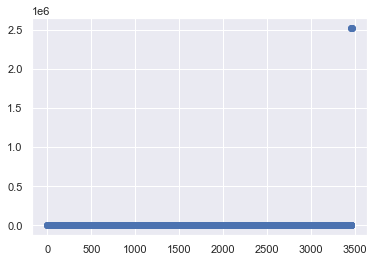

In [101]:
# Is id continuous?
plt.scatter(range(len(data.index)), data.index)

- There seems to have an outlier in the end of the series
- Id seems continuous (without the outlier)

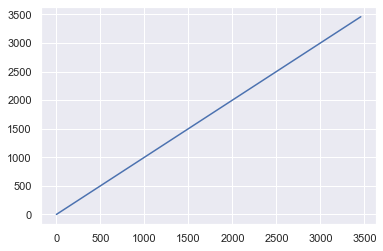

In [102]:
# (temprorarilly) Remove the outliers to zoom on the remaining ids
plt.plot(range(len(data.index[:-4])), data.index[:-4])

Analysis:
- Ids indeed seem continuous

Questions:
- Is there a meaning in the id? -> **YES**
- Is the id correlated with:
    - the type of starship?
    - the time (linear) -> **YES** (see eda_cleaning)
    - the year period (cyclical)

### Inspect stream_date

Text(0.5, 1.0, 'Complete date')

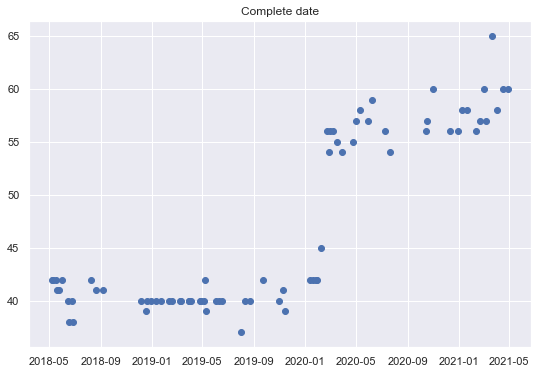

In [103]:
plt.figure(figsize=(9, 6))
date_counts = data['date'].value_counts()
plt.scatter(date_counts.index, date_counts.values)
plt.title('Complete date')

Analysis:
- There is a clear event at ±2020-02, with + half ships
- before 2020-02: number of ships within 38-42
- after 2020-02: number of ships within 54-60
- Seems like an outlier with 65 ships in ±2021-03

Questions:
- Was there a diminution / rupture of a certain type of ship before the event?
- What is the repartition of new ships?
    - if it is a general augmentation (for all types), it shouldn't be a diminution of one type of ship only
    - was it a progressive or a brutal diminution of ships?

#### Test hyp: more data points during estival period, fewer during winter (because ships are hidden in their boxes)

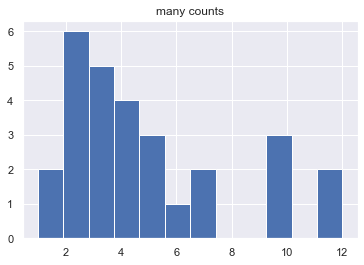

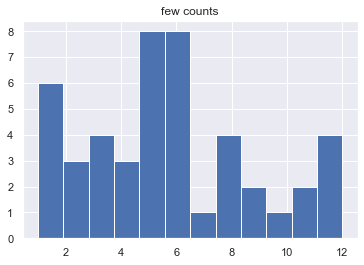

In [105]:
COUNT_LIMIT = 50

counts_by_date = data.groupby('date').count()
ma_many_ships = counts_by_date['ship_type'] > COUNT_LIMIT
months_many = counts_by_date[ma_many_ships].index.month
plt.hist(months_many, bins=12)
plt.title('many counts')
plt.show()

ma_few_ships = counts_by_date['ship_type'] < COUNT_LIMIT
months_few = counts_by_date[ma_few_ships].index.month
plt.hist(months_few, bins=12)
plt.title('few counts')
plt.show()

- There is no clear pattern. It is not correlated with specific months as expected

#### Test hyp: many data points during the week, fewer during week-end (because ships are hidden in their boxes)

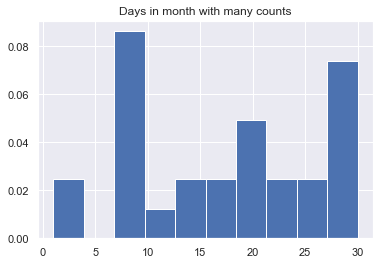

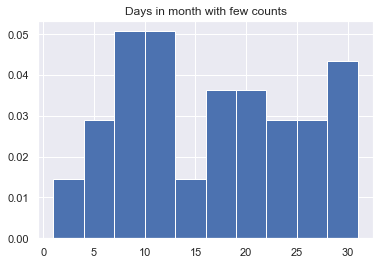

In [113]:
COUNT_LIMIT = 50

day_many = counts_by_date[ma_many_ships].index.day
plt.hist(day_many, density=True)
plt.title('Days in month with many counts')
plt.show()

day_few = counts_by_date[ma_few_ships].index.day
plt.hist(day_few, density=True)
plt.title('Days in month with few counts')
plt.show()

- There seems to have a slight increase around 10, 20 and 30
- SImilarily, there seems to have a slight decrease around 1 and 15
- These should be tested for their significance (might be random noise)

In [112]:
print(day_many)
print(day_few)

Int64Index([22, 25, 28,  7, 15, 27, 22,  1,  9, 30,  7,  9, 21, 13, 16, 30,  9,
            29,  7, 19, 10, 20, 28,  7, 20,  2, 16, 28],
           dtype='int64', name='date')
Int64Index([ 7, 11, 16, 19, 24,  1, 15, 18, 23, 26,  9, 20,  7,  6, 17, 19, 30,
            10, 21,  9, 17,  8, 11, 29, 30,  4, 25, 27,  4,  8, 10,  3, 10, 16,
            31, 10, 23, 22, 30,  8, 14, 11, 19, 26, 29,  6],
           dtype='int64', name='date')


### Investigate ship_type

#### Ship_type repartition

In [114]:
# Total period
data['ship_type'].value_counts()

TIE Fighter              2034
Imperial SpaceShuttle     827
TIE bomber                511
Civilian Star Shuttle      89
Surveillance droid          2
Name: ship_type, dtype: int64

In [115]:
# Get extreme dates
date_first = data['date'].min()
date_last = data['date'].max()

# Masks
ma_snap_first = data['date'] == date_first
ma_snap_last = data['date'] == date_last

# Extract ship_type for the given dates
ship_type_first = data[ma_snap_first]['ship_type'].value_counts()
ship_type_last = data[ma_snap_last]['ship_type'].value_counts()

In [116]:
ship_type_first

TIE Fighter              23
Imperial SpaceShuttle    11
TIE bomber                7
Civilian Star Shuttle     1
Name: ship_type, dtype: int64

In [117]:
ship_type_last

TIE Fighter              38
Imperial SpaceShuttle    13
TIE bomber                7
Civilian Star Shuttle     2
Name: ship_type, dtype: int64

#### Evolution of each ship_type

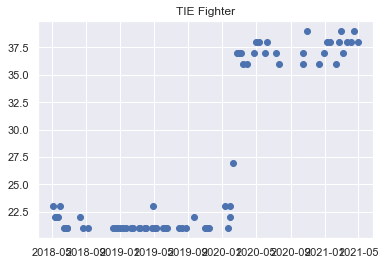

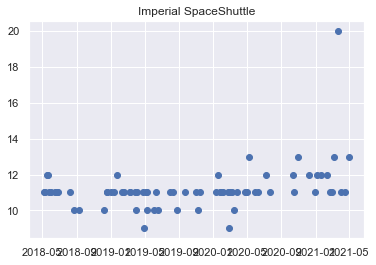

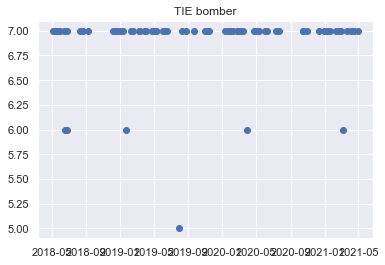

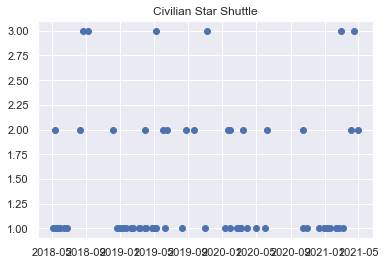

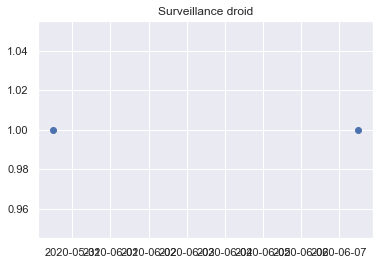

In [132]:
# Get the count of a ship_type for each date
for ship_type in data['ship_type'].value_counts().index:
    ma_ship_type = data['ship_type'] == ship_type
    evol_count = data[ma_ship_type].groupby('date').count()['ship_type']
    plt.scatter(evol_count.index, evol_count)
    plt.title(ship_type)
    plt.show()

- Surveillance droid:
    - only 2 points, could be due to:
        - noise: the CV detection algorithm made a mistake
        - hidden: since its a droid, it is never left outside so it is improbable to detect it? (only by chance)
    - otherwise constant over time


- Civilian star shuttle:
    - 3 modes [1, 2, 3] might be due to:
        - noise
        - some might be decommissioned: there seems to have a periodic pattern
    - Most often 1:
        - The remaining might often be hidden
    - otherwise constant over time


- TIE Bomber:
    - 3 modes [5, 6, 7]
    - Very often 7
    - 6 on a cyclical basis
    - otherwise constant over time


- Imperial SpaceShuttle:
    - very slight increase over time:
        - [10-12] before 2020-02
        - [11-13] after
    - might be a cyclical pattern going down and up again:
        - might be pure noise
        - might be solid, but when precisely and why?
    - Clear outlier when at 20 (once)


- TIE Fighter:
    - hugh increase over time:
        - [20-23] before event
        - [36-39] after event
        - has seen the highest increase (and single very significative)